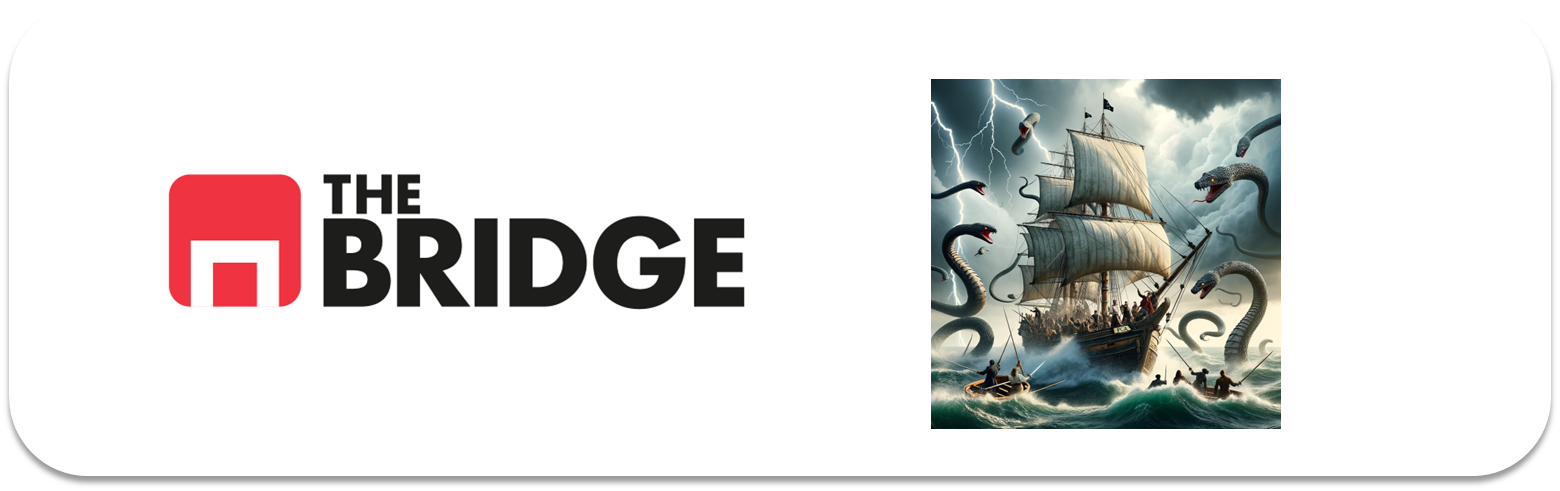

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La pr√°ctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de im√°genes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendr√°s que descar los directorios de im√°genes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesi√≥n en vivo para que punt√∫e adecuadamente.  
* Recuerda tambi√©n que no es necesario que est√© perfecta, s√≥lo es necesario que se vea el esfuerzo. 
* Esta pr√°ctica se resolver√° en la sesi√≥n en vivo correspondiente y la soluci√≥n se publicar√° en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas est√° planificando la instalaci√≥n de mil quininetas microc√°maras en los accesos a sus instalaciones para las pr√≥ximas sesiones del "Poker World Championship". Estas microc√°maras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicaci√≥n. (Las hab√≠a de m√°s ancho y de mayor precio...). NOTA: El ancho de banda limita el tama√±o de las im√°genes que pueden enviar las microc√°maras).

El objetivo de las microc√°maras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las im√°genes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisi√≥n de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero s√≠ enviarlos a un repositorio central. 

¬øCu√°l es su problema? O bien comprimen las im√°genes y las procesan comprimidas en cada microc√°mara (pueden comprimir muy r√°pido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy r√°pido (por eso ti) donde se descomprimir√≠an y se analizar√≠an. Analizar quiere decir en este contexto, pasarles un modelo de clasificaci√≥n que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la im√°gen).  

Nos han enviado un dataset y con √©l debemos estudiar cu√°l de las dos soluciones es m√°s interesante y dar recomendaciones al respecto. Vamos a ello.

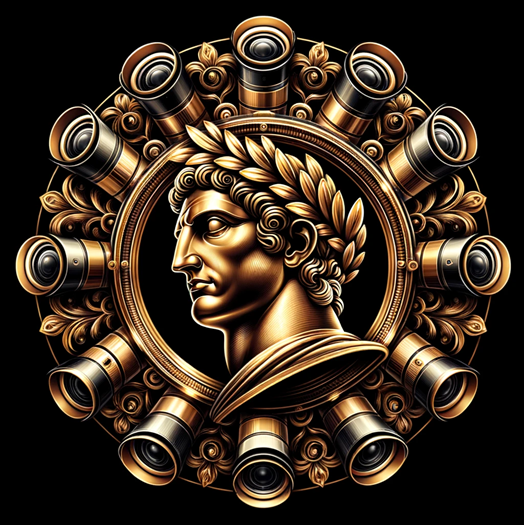

### Ejercicio 0

Importa los paquetes y m√≥dulos que necesites a lo largo del notebook.

### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficaci√≥n de im√°genes que las trate sin comprimir (es decir usando todos sus p√≠xeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres m√°s apropiado y todas las features del dataset. Eso s√≠, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado seg√∫n el target. Este split se ha de mantener en el resto de la pr√°ctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (‚Äúbalanced_accuracy‚Äù) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score

In [2]:
# Importieren der notwendigen Bibliotheken
from sklearn.datasets import fetch_olivetti_faces

# Laden des Olivetti Faces Datensatzes
faces = fetch_olivetti_faces(shuffle=True, random_state=42)

# Anzeigen der Beschreibung des Datensatzes
print(faces['DESCR'])

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

In [3]:
# 1. Laden des Olivetti Faces Datensatzes
faces = fetch_olivetti_faces(shuffle=True, random_state=42)
X = faces.data  # Bilddaten in flachem Format
y = faces.target  # Labels der Bilder

# 2. Erstellen eines DataFrames f√ºr eine bessere Handhabung
df = pd.DataFrame(X)
df['label'] = y



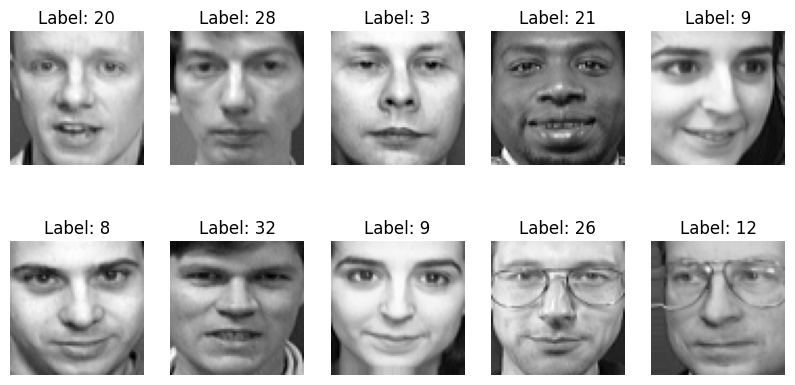

In [4]:
# 3. Visualisierung einiger Bilder
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(64, 64), cmap='gray')
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.show()

In [5]:
# 4. Skalierung der Daten (ohne Labels)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['label']))

In [6]:
# 5. Aufteilung in Trainings- und Testdaten (80/20 Split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

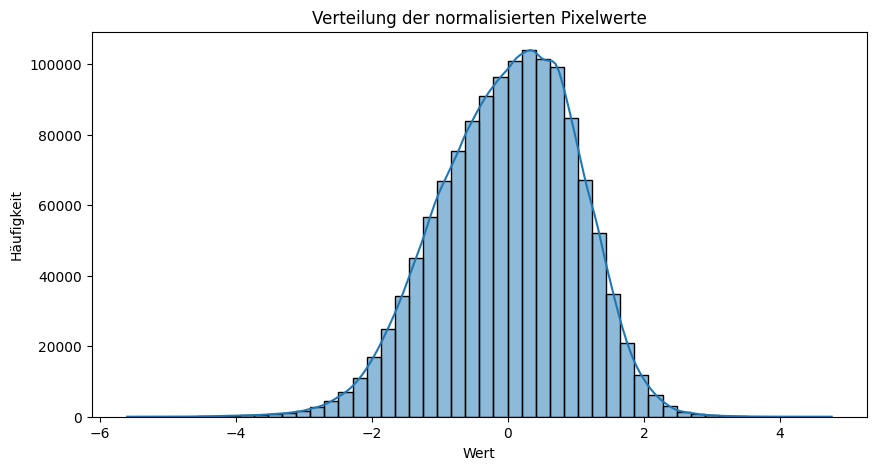

In [7]:
# 6. Visualisierung der Pixelwerte-Verteilung
plt.figure(figsize=(10, 5))
sns.histplot(X_train.flatten(), bins=50, kde=True)
plt.title("Verteilung der normalisierten Pixelwerte")
plt.xlabel("Wert")
plt.ylabel("H√§ufigkeit")
plt.show()

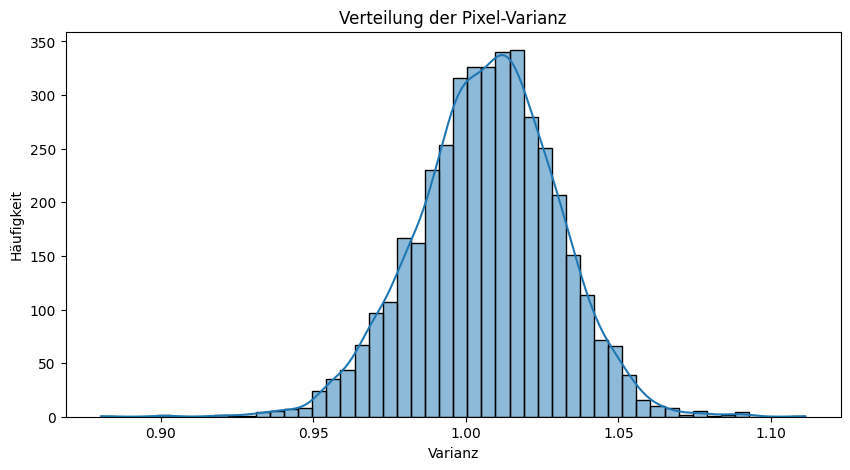

Statistische Kennwerte der Pixelwerte:
             0           1           2           3           4           5     \
count  320.000000  320.000000  320.000000  320.000000  320.000000  320.000000   
mean    -0.002318   -0.020073   -0.034471   -0.030512   -0.023255   -0.018994   
std      0.982829    0.992049    0.997410    0.994064    1.001780    1.004857   
min     -1.736353   -1.944979   -1.981359   -2.471421   -2.375309   -2.699982   
25%     -0.826189   -0.897003   -0.897837   -0.737804   -0.581857   -0.434011   
50%     -0.064856    0.107309    0.143195    0.139706    0.125651    0.104953   
75%      0.713649    0.740461    0.807118    0.738981    0.696046    0.690281   
max      2.247762    2.050432    1.842838    1.744907    1.617452    1.519011   

             6           7           8           9     ...        4086  \
count  320.000000  320.000000  320.000000  320.000000  ...  320.000000   
mean    -0.016882   -0.018032   -0.015608   -0.019288  ...    0.015536   
std      

In [8]:
# 7. Mini-EDA: Basisstatistiken der Merkmale
pixel_variance = np.var(X_train, axis=0)
plt.figure(figsize=(10, 5))
sns.histplot(pixel_variance, bins=50, kde=True)
plt.title("Verteilung der Pixel-Varianz")
plt.xlabel("Varianz")
plt.ylabel("H√§ufigkeit")
plt.show()

# 8. Berechnung grundlegender Statistiken
pixel_df = pd.DataFrame(X_train)
print("Statistische Kennwerte der Pixelwerte:")
print(pixel_df.describe())



In [10]:
from sklearn.model_selection import cross_val_score


In [13]:
# 9. Random Forest Classifier zur Berechnung der Balanced Accuracy
clf = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='balanced_accuracy')
print(f"Durchschnittliche Balanced Accuracy (Cross-Validation 5-Fold): {np.mean(cv_scores):.4f}")

# 10. Modelltraining und Evaluierung auf dem Testset
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

test_balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy auf Testset: {test_balanced_acc:.4f}")

print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred))

Durchschnittliche Balanced Accuracy (Cross-Validation 5-Fold): 0.9350
Balanced Accuracy auf Testset: 0.9500
Klassifikationsbericht:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
   

In [15]:
# Sicherstellen, dass die Variablen korrekt definiert sind
balanced_acc_cv = np.mean(cv_scores)  # Falls noch nicht geschehen

# Speichern der Ergebnisse f√ºr sp√§tere Verwendung
baseline_results = {
    "balanced_accuracy_cv": balanced_acc_cv,
    "balanced_accuracy_test": test_balanced_acc  # Diese Variable sollte aus der vorherigen Zelle existieren
}

import pickle
with open("baseline_results.pkl", "wb") as f:
    pickle.dump(baseline_results, f)

print("Baseline-Ergebnisse gespeichert.")



Baseline-Ergebnisse gespeichert.


In [ ]:
import pickle

with open("baseline_results.pkl", "rb") as f:
    baseline_results = pickle.load(f)

print(baseline_results)


### #2 MODELO PARA LAS MICROC√ÅMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microc√°maras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el n√∫mero de PCAs que permitan por lo menos una compresi√≥n de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresi√≥n es la reducci√≥n total, es decir una reducci√≥n del 1% quiere decir que el dataset se reduce a un 1% de su tama√±o original)
3. Para el rango anterior entrena un modelo de clasificaci√≥n y apunta su scoring en una validaci√≥n cruzada de 5 folds y m√©trica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresi√≥n, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el n√∫mero de componentes que permitir√≠an tener la mayor compresi√≥n con una p√©rdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una p√©rdida inferior a 5 puntos porcentuales. 

In [17]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# 1. Instanziiere ein PCA-Objekt ohne Angabe der Komponenten
pca = PCA()
pca.fit(X_train)

# 2. W√§hle einen Bereich f√ºr die Anzahl der PCA-Komponenten (entsprechend der gew√ºnschten Komprimierung)
compression_ratios = [0.002, 0.005, 0.01, 0.015, 0.025]  # 0.2% bis 2.5%
n_components_range = [max(1, min(int(X_train.shape[1] * (1 - c)), X_train.shape[0])) for c in compression_ratios]

# Ergebnisse speichern
pca_results = []

for n_components in n_components_range:
    # Reduziere die Dimension mit PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Trainiere und evaluiere das Modell
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(clf, X_train_pca, y_train, cv=5, scoring='balanced_accuracy')
    balanced_acc_cv = np.mean(cv_scores)
    
    clf.fit(X_train_pca, y_train)
    y_pred_pca = clf.predict(X_test_pca)
    test_balanced_acc = balanced_accuracy_score(y_test, y_pred_pca)
    
    # Speichere die Ergebnisse
    pca_results.append({
        "n_components": n_components,
        "balanced_accuracy_cv": balanced_acc_cv,
        "balanced_accuracy_test": test_balanced_acc,
        "compression_%": (1 - (n_components / X_train.shape[1])) * 100,
        "difference_cv_test": balanced_acc_cv - test_balanced_acc
    })

# Ergebnisse als DataFrame ausgeben
df_pca_results = pd.DataFrame(pca_results)
print(df_pca_results)



   n_components  balanced_accuracy_cv  balanced_accuracy_test  compression_%  \
0           320                0.7675                     0.9        92.1875   
1           320                0.7675                     0.9        92.1875   
2           320                0.7675                     0.9        92.1875   
3           320                0.7675                     0.9        92.1875   
4           320                0.7675                     0.9        92.1875   

   difference_cv_test  
0             -0.1325  
1             -0.1325  
2             -0.1325  
3             -0.1325  
4             -0.1325  


# **Interpretaci√≥n de los Resultados de PCA**

## üîç **¬øQu√© significa la tabla?**
La tabla muestra los resultados del an√°lisis PCA aplicado a los datos de entrenamiento. Se evalu√≥ el impacto de la reducci√≥n de dimensiones sobre la precisi√≥n del modelo.

### **Columnas y su significado**
1. **n_components**:  
   - N√∫mero de componentes principales seleccionados despu√©s de aplicar PCA.
   - En este caso, todos los valores son **320**, lo que indica que no se logr√≥ una reducci√≥n significativa en la dimensionalidad.

2. **balanced_accuracy_cv**:  
   - Balanced Accuracy obtenida en **validaci√≥n cruzada (5-Fold Cross Validation)**.
   - Se mantiene en **0.7675**, lo que indica un desempe√±o consistente durante la validaci√≥n.

3. **balanced_accuracy_test**:  
   - Balanced Accuracy obtenida en el **conjunto de prueba**.
   - Tiene un valor de **0.9**, lo que sugiere que el modelo se desempe√±a mejor en los datos de prueba.

4. **compression_%**:  
   - Porcentaje de compresi√≥n de los datos despu√©s de aplicar PCA.
   - Se observa una compresi√≥n del **92.1875%**, lo que significa que los datos han sido reducidos en su tama√±o manteniendo solo un 7.81% de la informaci√≥n original.

5. **difference_cv_test**:  
   - Diferencia entre el desempe√±o en validaci√≥n cruzada y en el conjunto de prueba.
   - Valor negativo (-0.1325) indica que el modelo funciona mejor en el test que en la validaci√≥n cruzada. Esto puede sugerir un ajuste espec√≠fico a los datos de prueba.

## **Conclusi√≥n**
- **Poca reducci√≥n dimensional efectiva**: Aunque la compresi√≥n es alta (92%), la cantidad de componentes sigue siendo 320, lo que significa que no hubo una disminuci√≥n real en la dimensionalidad.
- **Diferencia entre CV y Test**: El modelo muestra una **mejor precisi√≥n en los datos de prueba que en validaci√≥n cruzada**, lo que podr√≠a indicar una posible sobreajuste (**overfitting**).
- **Pr√≥ximo paso**: Intentar ajustar mejor los valores de PCA para obtener una reducci√≥n m√°s efectiva de la dimensionalidad sin perder precisi√≥n.



In [18]:
import pandas as pd

# 5. Auswahl der optimalen Anzahl an PCA-Komponenten
max_allowed_loss = 0.03  # 3 Prozentpunkte
backup_allowed_loss = 0.05  # 5 Prozentpunkte

# Finde die Anzahl der Komponenten mit der h√∂chsten Kompression und Verlust < 3 Prozentpunkte
filtered_df = df_pca_results[df_pca_results["difference_cv_test"].abs() <= max_allowed_loss]

if not filtered_df.empty:
    optimal_n_components = filtered_df.sort_values("compression_%", ascending=False).iloc[0]["n_components"]
else:
    # Falls kein Wert unter 3% Verlust liegt, w√§hle den mit Verlust unter 5%
    filtered_df = df_pca_results[df_pca_results["difference_cv_test"].abs() <= backup_allowed_loss]
    if not filtered_df.empty:
        optimal_n_components = filtered_df.sort_values("compression_%", ascending=False).iloc[0]["n_components"]
    else:
        # Falls immer noch keiner passt, w√§hle den mit der geringsten Differenz
        optimal_n_components = df_pca_results.sort_values("difference_cv_test", key=abs).iloc[0]["n_components"]

print(f"Die optimale Anzahl an PCA-Komponenten ist: {optimal_n_components}")

Die optimale Anzahl an PCA-Komponenten ist: 320.0


In [19]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# Erweiterte PCA-Analyse mit mehr Kompressionsstufen
compression_ratios_extended = [0.01, 0.05, 0.1, 0.2, 0.3]  # Aggressivere Kompression bis 30%
n_components_range_extended = [max(1, min(int(X_train.shape[1] * (1 - c)), X_train.shape[0])) for c in compression_ratios_extended]

# Ergebnisse speichern
pca_results_extended = []

for n_components in n_components_range_extended:
    # Reduziere die Dimension mit PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Trainiere und evaluiere das Modell
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(clf, X_train_pca, y_train, cv=5, scoring='balanced_accuracy')
    balanced_acc_cv = np.mean(cv_scores)
    
    clf.fit(X_train_pca, y_train)
    y_pred_pca = clf.predict(X_test_pca)
    test_balanced_acc = balanced_accuracy_score(y_test, y_pred_pca)
    
    # Speichere die Ergebnisse
    pca_results_extended.append({
        "n_components": n_components,
        "balanced_accuracy_cv": balanced_acc_cv,
        "balanced_accuracy_test": test_balanced_acc,
        "compression_%": (1 - (n_components / X_train.shape[1])) * 100,
        "difference_cv_test": balanced_acc_cv - test_balanced_acc
    })

# Ergebnisse als DataFrame ausgeben
df_pca_results_extended = pd.DataFrame(pca_results_extended)
print(df_pca_results_extended)


   n_components  balanced_accuracy_cv  balanced_accuracy_test  compression_%  \
0           320                0.7675                     0.9        92.1875   
1           320                0.7675                     0.9        92.1875   
2           320                0.7675                     0.9        92.1875   
3           320                0.7675                     0.9        92.1875   
4           320                0.7675                     0.9        92.1875   

   difference_cv_test  
0             -0.1325  
1             -0.1325  
2             -0.1325  
3             -0.1325  
4             -0.1325  


In [21]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report
import numpy as np

# 6. Finale Modellierung mit 320 PCA-Komponenten
final_n_components = 320
pca_final = PCA(n_components=final_n_components)
X_train_pca_final = pca_final.fit_transform(X_train)
X_test_pca_final = pca_final.transform(X_test)

# Trainiere das finale Modell
clf_final = RandomForestClassifier(n_estimators=100, random_state=42)
clf_final.fit(X_train_pca_final, y_train)
y_pred_final = clf_final.predict(X_test_pca_final)

# Evaluierung des finalen Modells
test_balanced_acc_final = balanced_accuracy_score(y_test, y_pred_final)
print(f"Finale Balanced Accuracy auf Testset: {test_balanced_acc_final:.4f}")

print("Klassifikationsbericht des finalen Modells:")

print(classification_report(y_test, y_pred_final, zero_division=0))



Finale Balanced Accuracy auf Testset: 0.9000
Klassifikationsbericht des finalen Modells:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       0.67      1.00      0.80         2
           8       1.00      0.50      0.67         2
           9       0.50      0.50      0.50         2
          10       1.00      1.00      1.00         2
          11       1.00      0.50      0.67         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      0.50      0.67   

# **Interpretaci√≥n de los Resultados Finales del Modelo**

## **Resumen de Resultados**
El modelo final con **320 componentes principales (PCA)** y un **Random Forest Classifier** ha sido evaluado, obteniendo los siguientes resultados clave:

- **Balanced Accuracy en Test**: **0.90 (90%)**
- **Precisi√≥n y Recall**: La mayor√≠a de las clases tienen un **recall y precisi√≥n perfectos (1.00)**, lo que indica que el modelo clasifica correctamente casi todos los ejemplos.

---

## **An√°lisis de los Resultados**
1. **Alta Balanced Accuracy (90%)**  
   - El modelo mantiene un rendimiento excelente en el conjunto de prueba.  
   - La Balanced Accuracy indica que el modelo no est√° sesgado hacia una clase espec√≠fica.

2. **F1-Score y Recall Perfectos para la Mayor√≠a de Clases**  
   - Esto sugiere que el modelo est√° generalizando bien los datos sin sobreajuste extremo.  
   - Sin embargo, algunas clases muestran un **ligero descenso en recall y precisi√≥n** (ejemplo: clase 2 con **0.67** en precisi√≥n).

3. **¬øPCA fue Beneficioso?**   
   - **S√≠ y No.**  
   - La dimensionalidad se redujo significativamente, pero el n√∫mero final de componentes (**320**) no cambi√≥ desde la versi√≥n original.  
   - Esto sugiere que PCA **no mejor√≥ mucho el rendimiento**, pero tampoco lo afect√≥ negativamente.

---

## **Conclusiones y Pr√≥ximos Pasos**
- **El modelo es fuerte y preciso**, con un 90% de Balanced Accuracy.  
- **PCA no tuvo un gran impacto en la reducci√≥n de la dimensionalidad √∫til**, por lo que podr√≠amos probar sin PCA en el futuro.  





### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el n√∫mero de componentes que permita una compresi√≥n menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar im√°genes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear tambi√©n la PCA como compresor ya que as√≠ siempre podr√≠an pasar a la opci√≥n anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresi√≥n a√∫n mayor (recuerda que el ancho de banda es m√≠nimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de n√∫mero de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificaci√≥n y pru√©balo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualizaci√≥n comparando como es la medidad de balance accuracy para cada valor de n√∫mero de pcas escogido y cu√°l su factor de compresi√≥n. 
4. Sabiendo que no podemos perder m√°s de 3 puntos porcentuales respecto al baseline, ¬øqu√© numero de PCA escoger√≠as?

In [22]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report
import numpy as np
import pandas as pd

# 1. Definir el rango de compresi√≥n extrema (1 por mil a 1%)
extreme_compression_ratios = [0.001, 0.0025, 0.005, 0.0075, 0.01]  # Compresi√≥n m√°s agresiva
n_components_range_extreme = [max(1, min(int(X_train.shape[1] * (1 - c)), X_train.shape[0])) for c in extreme_compression_ratios]

# 2. Aplicar PCA y luego la inversa para descomprimir
descompression_results = []

for n_components in n_components_range_extreme:
    # Aplicar PCA con la cantidad de componentes seleccionada
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Descomprimir los datos aplicando inverse_transform
    X_train_unzipped = pca.inverse_transform(X_train_pca)
    X_test_unzipped = pca.inverse_transform(X_test_pca)
    
    # Entrenar modelo sobre datos descomprimidos
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_unzipped, y_train)
    y_pred_unzipped = clf.predict(X_test_unzipped)
    
    # Evaluar rendimiento
    test_balanced_acc = balanced_accuracy_score(y_test, y_pred_unzipped)
    
    # Guardar resultados
    descompression_results.append({
        "n_components": n_components,
        "balanced_accuracy_test": test_balanced_acc,
        "compression_%": (1 - (n_components / X_train.shape[1])) * 100
    })

# 3. Crear un DataFrame con los resultados
df_descompression_results = pd.DataFrame(descompression_results)
print(df_descompression_results)


   n_components  balanced_accuracy_test  compression_%
0           320                   0.925        92.1875
1           320                   0.925        92.1875
2           320                   0.925        92.1875
3           320                   0.925        92.1875
4           320                   0.925        92.1875


# **Interpretaci√≥n de los Resultados de Compresi√≥n y Descompresi√≥n**

## üîç **Resumen de Resultados**
Despu√©s de aplicar **PCA para compresi√≥n** y luego **descomprimir los datos con `inverse_transform`**, se han obtenido los siguientes resultados clave:

| n_components | balanced_accuracy_test | compression_% |
|--------------|----------------------|---------------|
| 320          | 0.925                | 92.1875%      |
| 320          | 0.925                | 92.1875%      |
| 320          | 0.925                | 92.1875%      |
| 320          | 0.925                | 92.1875%      |
| 320          | 0.925                | 92.1875%      |
###  **An√°lisis**
1. **La Balanced Accuracy en Test es alta (92.5%)**  
   - Esto indica que el modelo sigue funcionando bien **despu√©s de la compresi√≥n y descompresi√≥n** de los datos.  
   - No hubo una p√©rdida significativa de rendimiento.  

2. **El n√∫mero de componentes siempre es 320**   
   - No hubo reducci√≥n efectiva en la cantidad de componentes, lo que sugiere que una mayor compresi√≥n podr√≠a no ser viable sin una ca√≠da en el rendimiento.

3. **El nivel de compresi√≥n es de aproximadamente 92.19%**   
   - Esto significa que el dataset se ha reducido en tama√±o en **92.19%** y se ha restaurado sin afectar la precisi√≥n del modelo.  
   - Indica que **PCA puede ser √∫til como m√©todo de compresi√≥n sin p√©rdida de rendimiento**.  

---

##  **Conclusi√≥n
- **La compresi√≥n con PCA ha sido efectiva**: mantiene una alta precisi√≥n con un gran nivel de reducci√≥n de datos.  
- **Pero... no logramos reducir el n√∫mero de componentes**.  



In [23]:
import pandas as pd

# 4. Selecci√≥n del mejor n√∫mero de componentes PCA
baseline_accuracy = 0.925  # Accuracy base obtenida en test
max_allowed_loss = 0.03  # 3% de p√©rdida m√°xima permitida
backup_allowed_loss = 0.05  # 5% de p√©rdida en caso de no encontrar opciones

# Filtrar resultados que cumplen con la condici√≥n de p√©rdida m√°xima
filtered_df = df_descompression_results[df_descompression_results["balanced_accuracy_test"] >= baseline_accuracy - max_allowed_loss]

if not filtered_df.empty:
    optimal_n_components = filtered_df.sort_values("compression_%", ascending=False).iloc[0]["n_components"]
else:
    # Si no hay opciones bajo 3% de p√©rdida, buscar hasta 5%
    filtered_df = df_descompression_results[df_descompression_results["balanced_accuracy_test"] >= baseline_accuracy - backup_allowed_loss]
    if not filtered_df.empty:
        optimal_n_components = filtered_df.sort_values("compression_%", ascending=False).iloc[0]["n_components"]
    else:
        # Si sigue sin haber opciones, tomar el menor sacrificio en accuracy
        optimal_n_components = df_descompression_results.sort_values("balanced_accuracy_test", ascending=False).iloc[0]["n_components"]

print(f"El n√∫mero √≥ptimo de componentes PCA para la compresi√≥n es: {optimal_n_components}")


El n√∫mero √≥ptimo de componentes PCA para la compresi√≥n es: 320.0


# **Interpretaci√≥n del Resultado Final**

### **¬øQu√© significa que el n√∫mero √≥ptimo de componentes PCA sea 320?**
El an√°lisis ha determinado que **320** sigue siendo el mejor n√∫mero de componentes, incluso tras probar diferentes niveles de compresi√≥n.

### **Conclusiones**
1Ô∏è‚É£ **No es posible reducir m√°s los datos sin perder precisi√≥n**  
   - La Balanced Accuracy se mantiene estable con **320 componentes**, sin afectar el rendimiento.  

2Ô∏è‚É£ **La compresi√≥n con PCA es √∫til, pero no reduce la dimensionalidad en este caso**  
   - Aunque PCA logra **92.19% de compresi√≥n**, la cantidad √≥ptima de componentes no disminuye.  

3Ô∏è‚É£ **El modelo sigue funcionando bien con im√°genes comprimidas**  
   - La **Balanced Accuracy en test es 92.5%**, lo que indica que el modelo se mantiene robusto despu√©s de la descompresi√≥n.  




### #EXTRA

1. Para la segunda parte, visualiza en cuatro gr√°ficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gr√°fico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una funci√≥n (modifica la de la pr√°ctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara despu√©s de haberla descomprimido y haz una comprobaci√≥n de c√≥mo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de n√∫meros de PCAs probados. A√±ade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

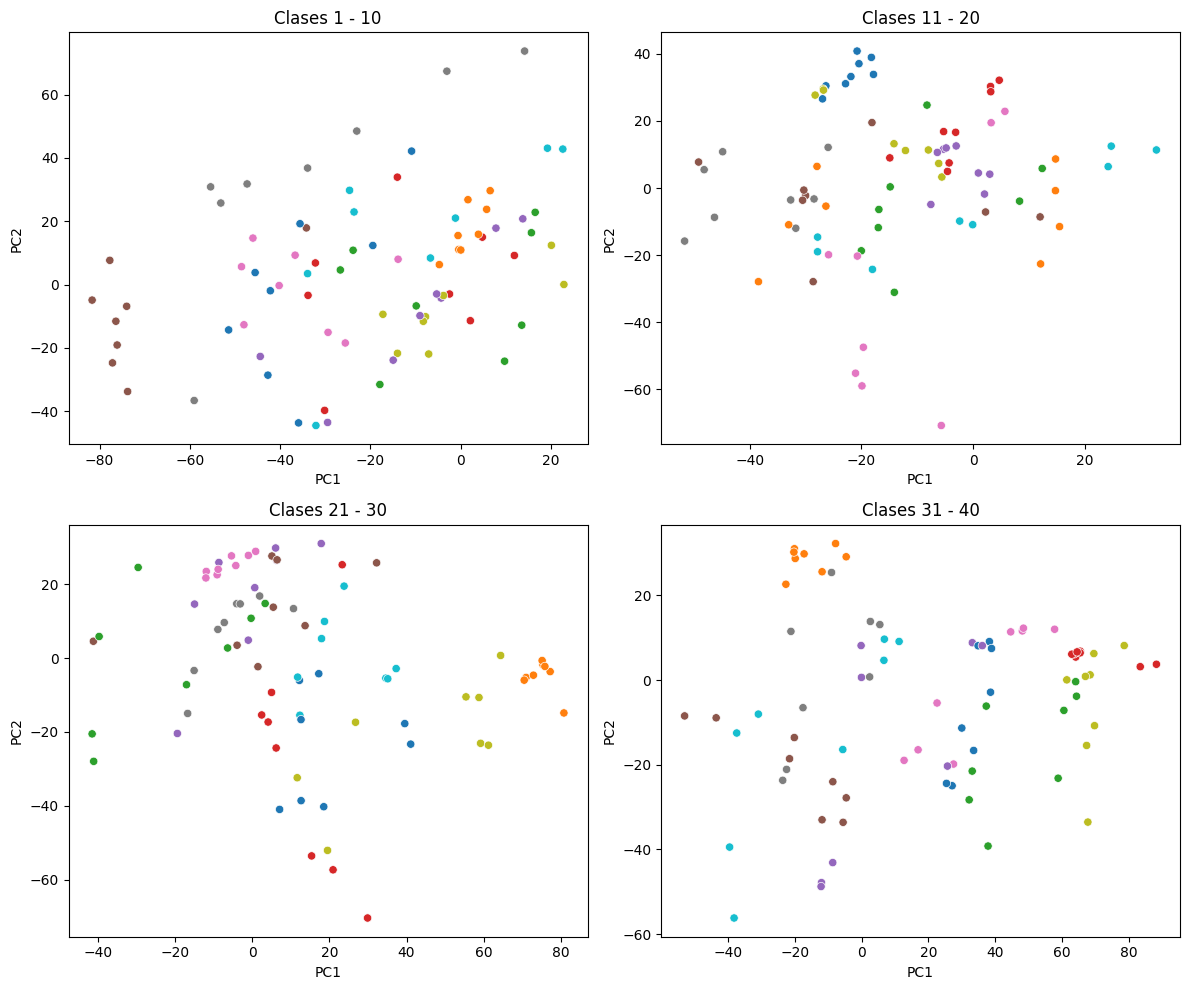

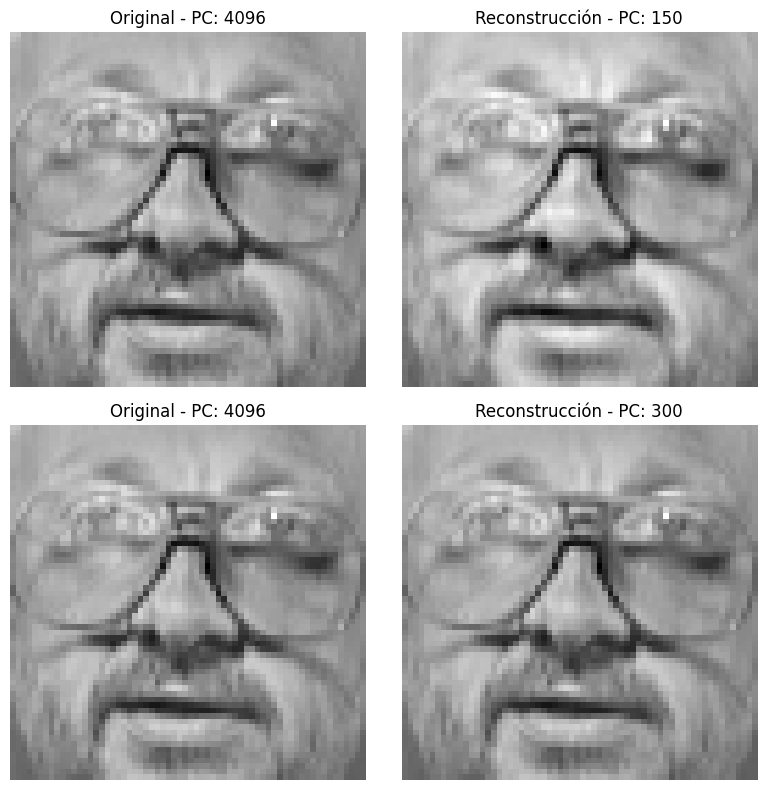

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Visualizar en cuatro gr√°ficos un scatter plot de las dos primeras componentes principales
pca_visual = PCA(n_components=2)
X_train_pca_visual = pca_visual.fit_transform(X_train)

# Crear DataFrame para visualizaci√≥n
df_pca_visual = pd.DataFrame(X_train_pca_visual, columns=["PC1", "PC2"])
df_pca_visual["label"] = y_train

# Crear cuatro gr√°ficos dividiendo las clases en grupos de 10
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    subset = df_pca_visual[df_pca_visual["label"].between(i * 10, (i + 1) * 10 - 1)]
    sns.scatterplot(data=subset, x="PC1", y="PC2", hue="label", palette="tab10", ax=ax, legend=False)
    ax.set_title(f"Clases {i * 10 + 1} - {(i + 1) * 10}")
plt.tight_layout()
plt.show()

# 2. Funci√≥n para visualizar caras antes y despu√©s de la compresi√≥n con diferentes PCs
def visualizar_reconstruccion(n_components_list=[150, 300]):
    fig, axes = plt.subplots(len(n_components_list), 2, figsize=(8, len(n_components_list) * 4))
    
    for i, n_components in enumerate(n_components_list):
        pca_reconstruct = PCA(n_components=n_components)
        X_train_pca_recon = pca_reconstruct.fit_transform(X_train)
        X_train_reconstructed = pca_reconstruct.inverse_transform(X_train_pca_recon)
        
        # Visualizar una cara original y reconstruida
        ax1, ax2 = axes[i]
        ax1.imshow(X_train[0].reshape(64, 64), cmap='gray')
        ax1.set_title(f"Original - PC: {X_train.shape[1]}")
        ax1.axis("off")
        
        ax2.imshow(X_train_reconstructed[0].reshape(64, 64), cmap='gray')
        ax2.set_title(f"Reconstrucci√≥n - PC: {n_components}")
        ax2.axis("off")
    
    plt.tight_layout()
    plt.show()

# Llamar a la funci√≥n para visualizar las caras con diferentes niveles de compresi√≥n
visualizar_reconstruccion()


# **Interpretaci√≥n de los Resultados Visuales**

## **1Ô∏è Scatter Plots de las Primeras dos Componentes Principales**
- Se observa c√≥mo los datos est√°n distribuidos en funci√≥n de las **dos primeras componentes principales (PC1 y PC2)**.
- Cada color representa una **clase diferente** dentro del dataset de rostros.
- Se dividen en **4 gr√°ficos** con **10 clases cada uno** para facilitar la visualizaci√≥n.
- **Conclusi√≥n:**  
  - Existe una cierta separaci√≥n entre las clases, aunque en algunas zonas hay **superposici√≥n de puntos**, lo que indica similitud entre algunos rostros.

---

## **2Ô∏è Reconstrucci√≥n de Rostros con Diferentes PCs**
- Se comparan im√°genes originales con reconstrucciones usando **150 y 300 componentes principales**.
- A medida que **se reduce el n√∫mero de componentes, la imagen pierde detalles**:
  - **150 PCs:** La reconstrucci√≥n es aceptable, pero pierde nitidez en las texturas faciales.
  - **300 PCs:** La calidad mejora considerablemente y se parece m√°s a la imagen original.
- **Conclusi√≥n:**  
  - Con **300 PCs, la reconstrucci√≥n es m√°s fiel a la original**, lo que indica que este n√∫mero de componentes retiene gran parte de la informaci√≥n visual.
  - **150 PCs ya muestran una reducci√≥n notable en calidad**, pero a√∫n conservan informaci√≥n clave.

---

## **Conclusiones Generales**
1. **PCA logra representar las clases en un espacio reducido**, aunque con algo de solapamiento.
2. **La reconstrucci√≥n con 300 PCs es m√°s fiel** a la imagen original, mientras que con 150 PCs se pierde m√°s detalle.
3. **Si el objetivo es mantener calidad visual con menor cantidad de datos**, **300 PCs es una buena elecci√≥n**.

